<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/NLP-Projects/blob/main/Syntactic%20Pattern%20Extraction%20Using%20NLTK/Syntactic_Pattern_Extraction_Using_NLTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Basic Setups

In [1]:
"""
NLTK Custom Syntactic Pattern Extraction

This script extracts custom syntactic patterns (e.g., NOUN+VERB, ADJ+NOUN) from the Brown Corpus
(news category), performs statistical analysis, and visualizes the results. It includes optional
topic-based analysis for economic-related patterns.
"""

import nltk
import pandas as pd
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional

import logging
logging.basicConfig(level="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings('ignore')

# Pattern Extractor Class

In [10]:
class SyntacticPatternExtractor:
    """A class to extract and analyze custom syntactic patterns using NLTK."""

    def __init__(self, corpus_category: str = "news", max_sentences: int = 1000):
        """
        Initialize with Brown Corpus and preprocessing tools.

        Args:
            corpus_category (str): Brown Corpus category (default: 'news').
            max_sentences (int): Maximum number of sentences to process (default: 1000).
        """
        try:
            nltk.download("brown", quiet=True)
            nltk.download("punkt", quiet=True)
            nltk.download("punkt_tab", quiet=True)
            nltk.download("averaged_perceptron_tagger_eng", quiet=True)
            self.sentences = brown.sents(categories=corpus_category)[:max_sentences]
            logger.info(f"Loaded {len(self.sentences)} sentences from Brown Corpus ({corpus_category})")
        except Exception as e:
            logger.error(f"Failed to load corpus: {e}")
            raise e

        self.patterns = []
        self.pattern_counts = Counter()
        self.sample_matches = {}
        self.economic_sentences = []

        # Define syntactic patterns to extract
        self.target_patterns = [
            ("NOUN", "VERB"),  # e.g., "jury said"
            ("ADJ", "NOUN"),   # e.g., "grand jury"
            ("VERB", "ADV"),   # e.g., "said quickly"
            ("NOUN", "NOUN"),  # e.g., "stock market"
            ("VERB", "NOUN"),  # e.g., "chase cats"
        ]
        logger.info(f"Defined {len(self.target_patterns)} target patterns")

    def preprocess(self) -> List[List[Tuple[str, str]]]:
        """Tokenize and POS-tag sentences."""
        tagged_sentences = []
        try:
            for sent in self.sentences:
                tokens = word_tokenize(" ".join(sent).lower())
                tagged = pos_tag(tokens)
                # Simplify POS tags to major categories
                simplified = [(word, self.simplify_pos(tag)) for word, tag in tagged]
                tagged_sentences.append(simplified)
            logger.info("Preprocessing completed")
            return tagged_sentences
        except Exception as e:
            logger.error(f"Preprocessing error: {e}")
            raise e

    def simplify_pos(self, tag):
        """Simplify POS tags to major categories."""
        if tag.startswith("NN"):
            return "NOUN"
        elif tag.startswith("VB"):
            return "VERB"
        elif tag.startswith("JJ"):
            return "ADJ"
        elif tag.startswith("RB"):
            return "ADV"
        else:
            return "OTHER"

    def extract_patterns(self, tagged_sentences):
        """Extract patterns from tagged sentences."""
        try:
            for sent in tagged_sentences:
                for i in range(len(sent) - 1):
                    pos1, pos2 = sent[i][1], sent[i + 1][1]
                    word1, word2 = sent[i][0], sent[i + 1][0]
                    pattern = (pos1, pos2)
                    if pattern in self.target_patterns:
                        self.patterns.append(pattern)
                        phrase = f"{word1} {word2}"
                        self.pattern_counts[pattern] += 1
                        # Store sample matches (up to 3 per pattern)
                        if pattern not in self.sample_matches:
                            self.sample_matches[pattern] = []
                        if len(self.sample_matches[pattern]) < 3:
                            self.sample_matches[pattern].append(phrase)
            logger.info(f"Extracted {len(self.patterns)} patterns")
        except Exception as e:
            logger.error(f"Pattern extraction error: {e}")
            raise e

    def extract_economic_patterns(self, tagged_sentences: List[List[Tuple[str, str]]]) -> Counter:
        """Extract patterns from sentences related to economics."""
        economic_keywords = {"market", "stock", "economy", "trade", "finance", "bank"}
        economic_counts = Counter()
        try:
            for sent in tagged_sentences:
                words = [word for word, _ in sent]
                if any(keyword in words for keyword in economic_keywords):
                    self.economic_sentences.append(sent)
                    for i in range(len(sent) - 1):
                        pos1, pos2 = sent[i][1], sent[i + 1][1]
                        pattern = (pos1, pos2)
                        if pattern in self.target_patterns:
                            economic_counts[pattern] += 1
            logger.info(f"Found {len(self.economic_sentences)} economic-related sentences")
            return economic_counts
        except Exception as e:
            logger.error(f"Economic pattern extraction error: {e}")
            raise e

    def analyze_patterns(self, economic_counts: Optional[Counter] = None) -> pd.DataFrame:
        """Perform statistical analysis on extracted patterns."""
        total_patterns = len(self.patterns)
        data = []
        try:
            for pattern in self.target_patterns:
                count = self.pattern_counts[pattern]
                percentage = (count / total_patterns * 100) if total_patterns > 0 else 0
                economic_count = economic_counts[pattern] if economic_counts else 0
                economic_percentage = (economic_count / count * 100) if count > 0 else 0
                data.append({
                    "Pattern": f"{pattern[0]}+{pattern[1]}",
                    "Count": count,
                    "Percentage (%)": round(percentage, 2),
                    "Economic Count": economic_count,
                    "Economic Percentage (%)": round(economic_percentage, 2),
                    "Sample Matches": ", ".join(self.sample_matches.get(pattern, []))
                })
            df = pd.DataFrame(data)
            logger.info("Statistical analysis completed")
            return df.sort_values(by="Count", ascending=False)
        except Exception as e:
            logger.error(f"Analysis error: {e}")
            raise e

    def visualize_results(self, df: pd.DataFrame, output_dir: str = "output") -> None:
        """Visualize pattern distribution."""
        try:
            Path(output_dir).mkdir(exist_ok=True)

            # Plot 1: Overall pattern distribution
            plt.figure(figsize=(10, 6))
            sns.barplot(x="Pattern", y="Count", data=df, palette="viridis")
            plt.title("Distribution of Syntactic Patterns in News Corpus", fontsize=14, fontweight="bold")
            plt.xlabel("Syntactic Pattern")
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f"{output_dir}/pattern_distribution.png")
            plt.show()

            # Plot 2: Economic vs. Overall patterns
            if df["Economic Count"].sum() > 0:
                # بررسی وجود ستون‌ها
                required_columns = ["Pattern", "Count", "Economic Count"]
                if not all(col in df.columns for col in required_columns):
                    logger.error(f"Required columns {required_columns} not found in DataFrame")
                    return

                # ذوب کردن DataFrame با نام‌های واضح
                df_melted = pd.melt(
                    df,
                    id_vars=["Pattern"],
                    value_vars=["Count", "Economic Count"],
                    var_name="Count_Type",
                    value_name="Value"
                )
                plt.figure(figsize=(10, 6))
                sns.barplot(x="Pattern", y="Value", hue="Count_Type", data=df_melted, palette="magma")
                plt.title("Overall vs. Economic Syntactic Patterns", fontsize=14, fontweight="bold")
                plt.xlabel("Syntactic Pattern")
                plt.ylabel("Count")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(f"{output_dir}/economic_comparison.png")
                plt.show()

            logger.info("Visualizations saved")
        except Exception as e:
            logger.error(f"Visualization error: {e}")
            raise e

    def save_results(self, df: pd.DataFrame, filepath: str = "output/pattern_analysis.csv") -> None:
        """Save analysis results to a CSV file."""
        try:
            Path(filepath).parent.mkdir(exist_ok=True)
            df.to_csv(filepath, index=False)
            logger.info(f"Results saved to {filepath}")
        except Exception as e:
            logger.error(f"Save error: {e}")
            raise e


Top Syntactic Patterns in News Category:
  Pattern  Count  Percentage (%)                                      Sample Matches
NOUN+NOUN   2711           34.11  fulton county, city executive, executive committee
 ADJ+NOUN   2590           32.59 grand jury, primary election, term-end presentments
NOUN+VERB   1595           20.07   jury said, election produced, irregularities took
VERB+NOUN    660            8.30          took place, investigate reports, allen jr.
 VERB+ADV    392            4.93                are well, follow generally, was also

Economic Patterns Analysis:
  Pattern  Economic Count  Economic Percentage (%)                                      Sample Matches
NOUN+NOUN              40                     1.48  fulton county, city executive, executive committee
 ADJ+NOUN              33                     1.27 grand jury, primary election, term-end presentments
NOUN+VERB              12                     0.75   jury said, election produced, irregularities took
VERB+NO

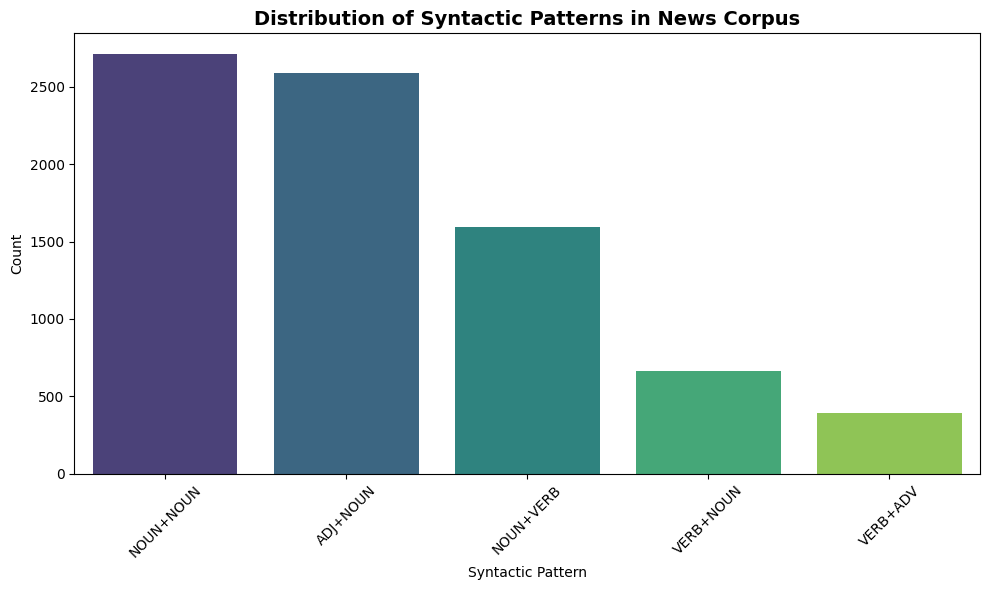

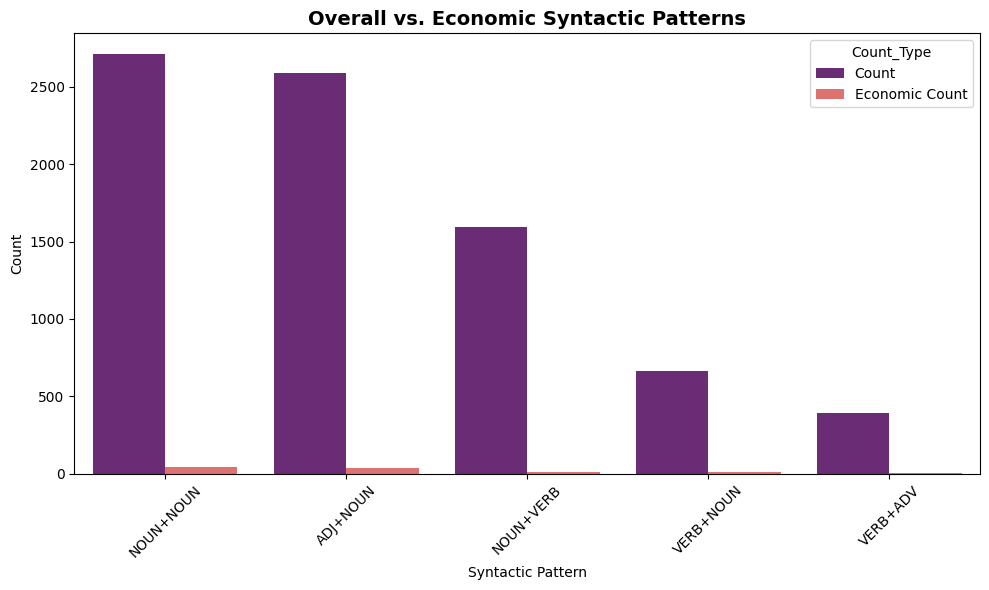

In [11]:
def main():
    """Main function to execute the syntactic pattern extraction."""
    try:
        # Initialize extractor
        extractor = SyntacticPatternExtractor(max_sentences=2000)  # محدود به 2000 جمله برای سرعت

        # Preprocess corpus
        tagged_sentences = extractor.preprocess()

        # Extract patterns
        extractor.extract_patterns(tagged_sentences)

        # Extract economic patterns
        economic_counts = extractor.extract_economic_patterns(tagged_sentences)

        # Analyze patterns
        df = extractor.analyze_patterns(economic_counts)

        # Display results
        print("\nTop Syntactic Patterns in News Category:")
        print(df[["Pattern", "Count", "Percentage (%)", "Sample Matches"]].to_string(index=False))

        print("\nEconomic Patterns Analysis:")
        print(df[["Pattern", "Economic Count", "Economic Percentage (%)", "Sample Matches"]].to_string(index=False))

        # Visualize results
        extractor.visualize_results(df)

        # Save results
        extractor.save_results(df)
    except Exception as e:
        logger.error(f"Main execution error: {e}")


main()